# Прогноз курса акций с использованием RNN - рекуррентной нейронной сети



![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1920px-Recurrent_neural_network_unfold.svg.png)

### Прогнозирование курса акций

Прогнозирование цен на акции - это попытка определить будущее акций компании. Это можно сделать, проанализировав прошлые данные.

### Imports

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

### Загружаем датасет.
Для наших данных мы будем использовать датасет AAPL_data с Kaggle.
Он имеет семь признаков: date, open, high, low, close, volume и name.

In [70]:
df = pd.read_csv('/AAPL_data.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


### Предварительная обработка и извлечение признаков

In [71]:
df = df['open'].values
df = df.reshape(-1, 1)
print(df.shape)
df[:5]

(1259, 1)


array([[67.7142],
       [68.0714],
       [68.5014],
       [66.7442],
       [66.3599]])

In [73]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1007, 1)
(302, 1)


In [74]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.155509],
       [0.160029],
       [0.16547 ],
       [0.143235],
       [0.138373]])

In [75]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.704862],
       [0.708658],
       [0.700433],
       [0.710809],
       [0.695182]])

In [76]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y 

In [77]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[0.155509, 0.160029, 0.16547 , 0.143235, 0.138373, 0.1462  , 0.132192, 0.126027, 0.104896, 0.110771, 0.119085,
        0.100956, 0.109289, 0.101372, 0.090436, 0.071997, 0.060574, 0.084127, 0.066032, 0.075612, 0.075522, 0.086097,
        0.073173, 0.08109 , 0.090309, 0.096671, 0.129299, 0.125538, 0.112524, 0.120405, 0.13868 , 0.140037, 0.123804,
        0.111801, 0.097485, 0.071637, 0.07845 , 0.082772, 0.066032, 0.066665, 0.069394, 0.07254 , 0.082698, 0.083476,
        0.070551, 0.060736, 0.058386, 0.030766, 0.      , 0.008442]])

In [78]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.704862, 0.708658, 0.700433, 0.710809, 0.695182, 0.680061, 0.690564, 0.684237, 0.6812  , 0.701446, 0.719793,
        0.732193, 0.739152, 0.754336, 0.758638, 0.77243 , 0.763953, 0.775847, 0.776606, 0.770912, 0.761296, 0.773063,
        0.785716, 0.772177, 0.774708, 0.763953, 0.764585, 0.765471, 0.776353, 0.791157, 0.801533, 0.801153, 0.803115,
        0.805835, 0.796092, 0.817097, 0.809505, 0.822791, 0.817097, 0.811403, 0.822411, 0.838228, 0.844175, 0.828864,
        0.831648, 0.906049, 0.918007, 0.922246, 0.932621, 0.950462]])

In [79]:
# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Building Model

In [80]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [81]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [84]:
if(not os.path.exists('stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save('stock_prediction.h5')

In [82]:
model = load_model('stock_prediction.h5')

### Визуализирование результатов

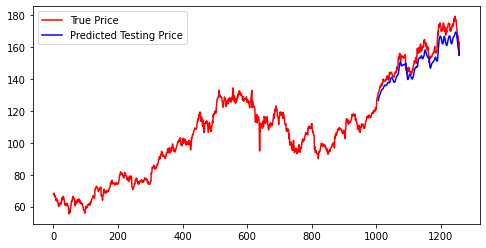

In [83]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

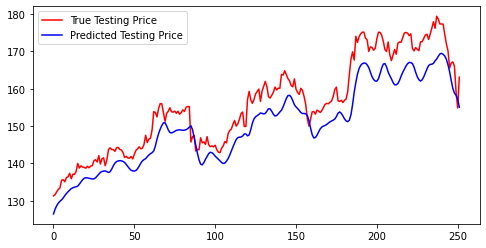

In [85]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()

In [86]:
x = x_test[-1]
num_timesteps = 100
preds = []
for i in range(num_timesteps):
    data = np.expand_dims(x, axis=0)
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    preds.append(prediction[0][0])
    x = np.delete(x, 0, axis=0) # delete first row
    x = np.vstack([x, prediction]) # add prediction

print(preds)

[155.04558, 243.88284, 275.4856, 280.35233, 282.4214, 282.84595, 282.8768, 282.73712, 282.56778, 282.4084, 282.27386, 282.16586, 282.08203, 282.01846, 281.97128, 281.9371, 281.91296, 281.89648, 281.88593, 281.8798, 281.8767, 281.87622, 281.87738, 281.87994, 281.88336, 281.88748, 281.89197, 281.89694, 281.902, 281.9075, 281.91306, 281.91867, 281.9244, 281.9303, 281.9364, 281.9429, 281.94986, 281.95795, 281.96744, 281.9788, 281.99255, 282.00858, 282.02573, 282.0417, 282.05273, 282.0536, 282.03653, 281.99255, 281.9128, 281.79752, 281.64264, 281.61096, 281.6081, 281.6078, 281.60776, 281.60782, 281.60794, 281.6081, 281.60828, 281.6084, 281.60843, 281.60855, 281.60858, 281.60864, 281.6087, 281.6088, 281.6088, 281.60886, 281.6089, 281.60892, 281.60898, 281.60904, 281.60913, 281.6091, 281.60913, 281.6092, 281.60928, 281.6093, 281.60938, 281.6094, 281.6094, 281.60953, 281.60953, 281.6096, 281.60962, 281.60965, 281.6098, 281.60977, 281.60977, 281.60986, 281.60992, 281.60992, 281.61002, 281.61008

## Ресурсы

<ul>
    <li><a href="https://en.wikipedia.org/wiki/Stock_market_prediction">Stock market prediction (Wikipedia)</a></li>
    <li><a href="https://towardsdatascience.com/stock-prediction-in-python-b66555171a2">Stock Prediction in Python (William Koehrsen on Medium)</a></li>
    